# Regression analysis: fitting the yield model

We fit each county individually ensuring coefficients exhibit the correct sign. We then check for which counties the yield model adds significant skill by using an F-test.

In [12]:
import numpy as np
import pandas as pd
import geopandas as gp
import sklearn.preprocessing as sklp
import sklearn.metrics as sklm
import scipy.optimize as sso
import scipy.stats as ss
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['font.size'] = 22
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['pdf.fonttype'] = 42

# http://www.fabiocrameri.ch/colourmaps.php
cm_data = np.loadtxt("../../plotting_tools/turku.txt")[::-1]
turku_map = LinearSegmentedColormap.from_list("Turku", cm_data)

In [2]:
# Import plotting shapefiles
county_shp = gp.read_file('../../plotting_tools/counties_contig_plot.shp')
county_shp["GEOID"] = county_shp["GEOID"].astype(str).str.zfill(5)

states = gp.read_file('../../plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../../plotting_tools/coast_contig_plot.shp')

### Data Processing

In [11]:
usda_county

county_name  asd_code  county_code  yield state_alpha  \
GEOID year                                                         
01001 1950     AUTAUGA        50            1   17.0          AL   
      1951     AUTAUGA        50            1   13.0          AL   
      1952     AUTAUGA        50            1    9.0          AL   
      1953     AUTAUGA        50            1   20.0          AL   
      1954     AUTAUGA        50            1   11.0          AL   
...                ...       ...          ...    ...         ...   
56045 1981      WESTON        20           45   30.0          WY   
      1982      WESTON        20           45   39.0          WY   
      1983      WESTON        20           45   99.0          WY   
      1984      WESTON        20           45   84.0          WY   
      1986      WESTON        20           45   95.0          WY   

           state_fips_code     area  log_yield  quad_fit  yield_anom  
GEOID year                                                            
01001 1950              01  29600.0   2.833213  2.986427   -0.153214  
      1951              01  29100.0   2.564949  3.005359   -0.440410  
      1952              01  24400.0   2.197225  3.024518   -0.827294  
      1953              01  24400.0   2.995732  3.043904   -0.048171  
      1954              01  24400.0   2.397895  3.063516   -0.665620  
...                    ...      ...        ...       ...         ...  
56045 1981              56    100.0   3.401197  3.960387   -0.559190  
      1982              56    100.0   3.663562  4.027675   -0.364113  
      1983              56    400.0   4.595120  4.097028    0.498092  
      1984              56    300.0   4.430817  4.168448    0.262369  
      1986              56    100.0   4.553877  4.317487    0.236390  

[143635 rows x 10 columns]

In [3]:
# GMFD
gmfd = pd.read_csv('../../agvars/GMFD/agvar_historical_gmfd.csv')
gmfd.sort_values(by = ['GEOID', 'Year'], inplace = True)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd["GEOID"] = gmfd["GEOID"].astype(str).str.zfill(5)
gmfd.set_index(['GEOID', 'Year'], inplace = True)

# USDA with county trends
usda_county = pd.read_csv('../../usda/output/USDA_county_yields_w_county_quad_trends.csv')
usda_county['state_fips_code'] = usda_county["state_fips_code"].astype(str).str.zfill(2)
usda_county["GEOID"] = usda_county["GEOID"].astype(str).str.zfill(5)
usda_county.sort_values(by = ['GEOID', 'year'], inplace = True)
usda_county.set_index(['GEOID', 'year'], inplace = True)

def get_features(usda_data, minYears = 23):
    # Merge
    features = pd.merge(usda_data.query("year <= 2005 and year >= 1960").reset_index().filter(['GEOID', 'year', 'yield_anom', 'log_yield', 'quad_fit']), gmfd.query("Year <= 2005 and Year >= 1960").reset_index(), left_on = ['GEOID', 'year'], right_on = ['GEOID', 'Year'], how = 'inner')
    features.drop(columns = ['Year'], inplace = True)
    features.set_index(['GEOID', 'year'], inplace = True)
    
    # Select minimum number of years for each county
    features['count'] = 1.
    minFeatures = features.groupby('GEOID').sum().query('count >= ' + str(minYears)).index
    # Select minimum number of years for each county
    features = features.loc[minFeatures].drop(columns = ['count'])
    print('Final shape of features: ' + str(features.shape))
    return features

In [4]:
# Features
features = get_features(usda_county)
features['egdd'] = -features['egdd']
features['prcp2'] = -features['prcp2']

Final shape of features: (99403, 7)


### Do the fit

In [5]:
# F-test parameters
pbase = 2
pfull = 6

In [6]:
# Drop NaNs
features = features.dropna()

In [7]:
NNLS = {}
for geoid in features.index.unique(level = 'GEOID'):
    # Predictors, targets
    predictors = sklp.scale(features.loc[geoid].filter(['gdd', 'egdd', 'prcp', 'prcp2']).to_numpy(), with_std=False)
    targets = sklp.scale(features.loc[geoid]['yield_anom'].to_numpy(), with_std=False)
    
    # Scipy NNLS
    model_object = sso.nnls(predictors, targets)
    # R2
    prediction = model_object[0][0]*predictors[:,0] + model_object[0][1]*predictors[:,1] + model_object[0][2]*predictors[:,2] + model_object[0][3]*predictors[:,3]
    r2 = sklm.r2_score(targets, prediction)
    
    # F-test 
    n = len(targets)
    RSSbase = np.sum(targets**2)
    RSSfull = np.sum((prediction - targets)**2)
    F = ((RSSbase - RSSfull)/(pfull-pbase))/(RSSfull/(n-pfull-1))
    pval = ss.f.sf(F, pfull - pbase, n - pfull - 1)
    # Store
    NNLS.update({geoid : [model_object[0][0], -model_object[0][1], model_object[0][2], -model_object[0][3], r2, pval]})
    
NNLS_res = pd.DataFrame.from_dict(NNLS, orient = 'index', columns = ['GDDc', 'KDDc', 'Pc', 'P2c', 'R2', 'pval'])
NNLS_res.index.name = 'GEOID'

In [8]:
NNLS_res

,GDDc,KDDc,Pc,P2c,R2,pval
GEOID,,,,,,
01001,0.000650,-0.009133,0.638664,-0.306875,0.452173,7.862108e-05
01003,0.000000,-0.002219,1.515195,-0.644551,0.199122,7.038708e-02
01005,0.000148,-0.004832,0.820174,-0.524230,0.337459,2.971402e-03
01009,0.000977,-0.010829,0.000000,-0.538866,0.631368,7.569497e-08
01011,0.000290,-0.006119,0.000000,-0.099910,0.294675,2.883050e-02
...,...,...,...,...,...,...
56021,0.000436,-0.002096,0.391443,-0.023327,0.015359,9.643924e-01
56025,0.000000,-0.000000,0.000000,-0.284330,0.000684,9.999545e-01
56029,0.000549,-0.007749,1.634884,-2.553672,0.033599,8.499879e-01


In [9]:
# Save
NNLS_res.to_csv('./ag_model_coeff_final.csv')

## Results

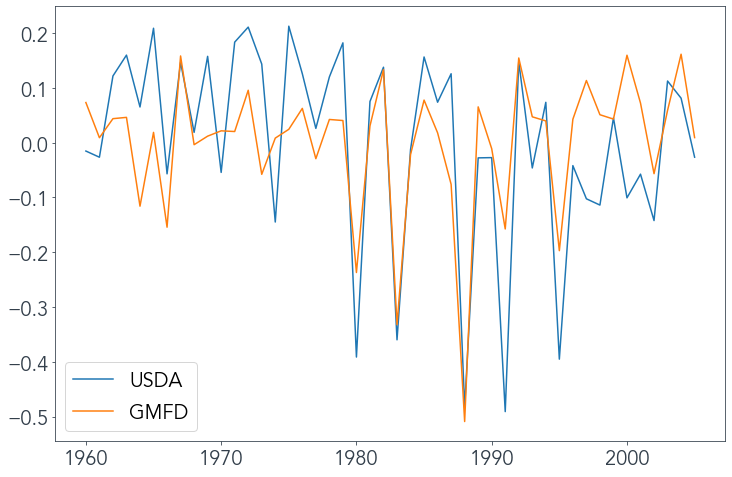

In [10]:
# Example time series
geoid = '17019'
fig, ax = plt.subplots(1,1, figsize = (12,8))
truth = sklp.scale(features.loc[geoid]['yield_anom'], with_std = False)
predictors = sklp.scale(features.loc[geoid].filter(['gdd', 'egdd', 'prcp', 'prcp2']).to_numpy(), with_std=False)
res = NNLS_res.loc[geoid]
sim = res['GDDc']*predictors[:,0] - res['KDDc']*predictors[:,1] + res['Pc']*predictors[:,2] - res['P2c']*predictors[:,3]
ax.plot(features.loc[geoid].index, truth, label = 'USDA')
ax.plot(features.loc[geoid].index, sim, label = 'GMFD')

plt.legend()
plt.show()

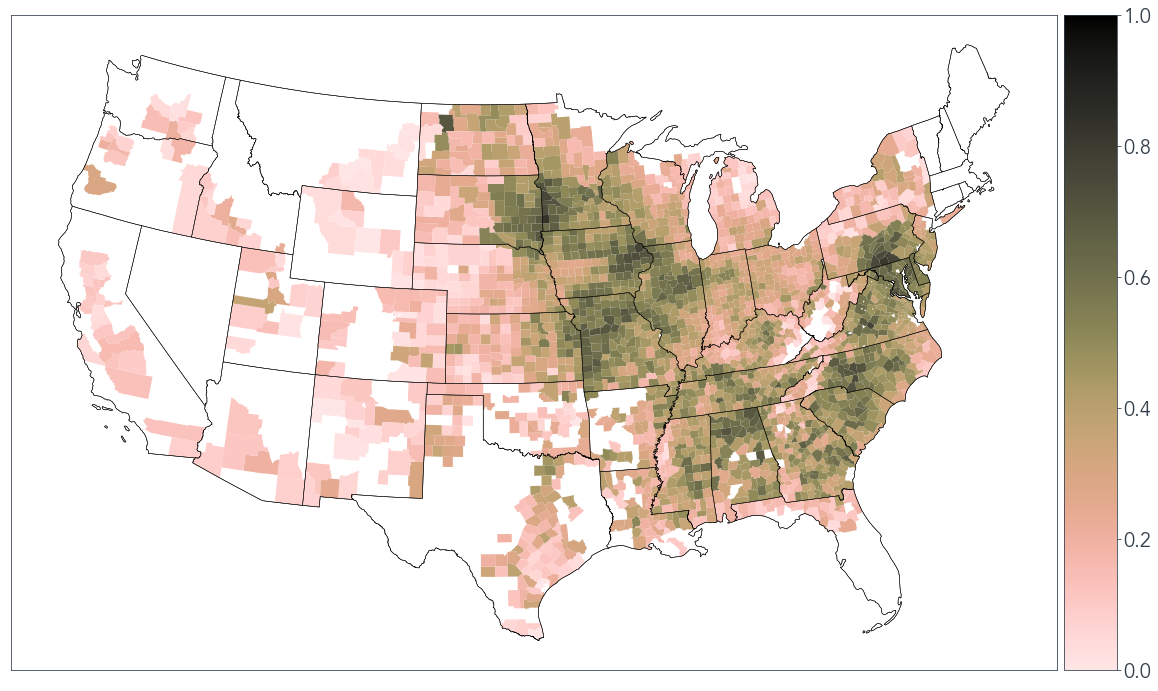

In [11]:
# Plot all R-squared
fig, ax = plt.subplots(1,1, figsize=(18, 10))
data = NNLS_res.reset_index()
data_shp = pd.merge(county_shp, data, on="GEOID", how="outer", copy=False)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
data_shp.dropna().plot(column='R2', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'ticks' : np.arange(0.,1.1,0.2)}, vmin = 0., vmax = 1.0, cmap=turku_map)
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

plt.tight_layout()
plt.show()

## Figure 1

Note this will only correspond exactly to Figure 1 in the main text if `f_tested = False` and `weighted = True` above. Other combinations can be found in the Supplementary Information.

In [5]:
# If needed
NNLS_res = pd.read_csv('./ag_model_coeff_final.csv')
NNLS_res['GEOID'] = NNLS_res['GEOID'].astype(str).str.zfill(5)

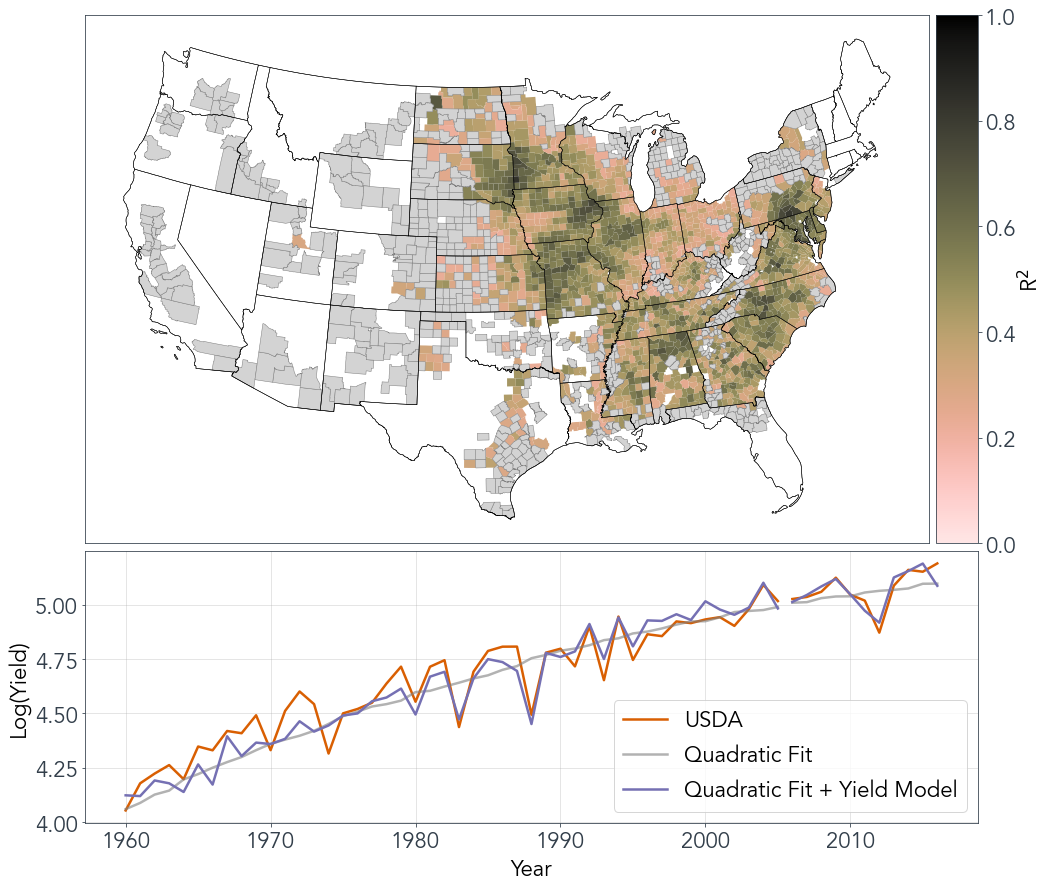

In [17]:
###############################
# Select aggregation options
f_tested = False     # if True, include counties with F-test p-value < 0.05
weighted = True    # if True, do weighted aggregation based on mean historical county production shares
###############################

# Calculate the postdictions
gmfd_plot = gmfd.copy()
gmfd_plot['prcp2'] = gmfd_plot['prcp']**2
    
# Subtract means
for agvar in gmfd_plot.columns:
    gmfd_plot[agvar] = gmfd_plot[agvar] - gmfd_plot[agvar].mean(level = 'GEOID')
gmfd_plot = pd.merge(gmfd_plot.reset_index(), NNLS_res.reset_index(), on=['GEOID'], how = 'inner')
gmfd_plot['gmfd_yield'] = gmfd_plot['gdd']*gmfd_plot['GDDc'] + gmfd_plot['egdd']*gmfd_plot['KDDc'] + gmfd_plot['prcp']*gmfd_plot['Pc'] + gmfd_plot['prcp2']*gmfd_plot['P2c']

# Select what we need for plot
gmfd_plot = pd.merge(usda_county.reset_index().filter(['GEOID', 'year', 'yield_anom', 'log_yield', 'quad_fit']), gmfd_plot.reset_index().filter(['GEOID', 'Year', 'gmfd_yield']), left_on = ['GEOID', 'year'], right_on = ['GEOID', 'Year'], how = 'inner')
gmfd_plot.drop(columns = ['Year'], inplace = True)
gmfd_plot.set_index(['GEOID', 'year'], inplace = True)

# F-tested or not
if f_tested:
    p05_counties = NNLS_res.query('pval < 0.05').index.unique()
    gmfd_plot = gmfd_plot.loc[p05_counties]

# Weight function (different if applied with(out) F-test filtering)
def do_weighting(data):
    # Construct national weights (total production by weighted sum of counties)
    weights = usda_county.filter(["area","yield"])
    weights["national_weight"] = weights["area"] * weights["yield"]
    weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
    # Normalise
    weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
    weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
    weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
    weights = weights.set_index(['GEOID','year']).sort_index()
    weights = weights.filter(['national_weight'])
    # Merge
    data = pd.merge(data.reset_index(), weights.reset_index(), on = ['GEOID','year'], how = 'inner')
    data.set_index(['GEOID', 'year'], inplace = True)
    
    # Sum
    data['gmfd_yield'] = data['gmfd_yield'] * data['national_weight']
    data['quad_fit'] = data['quad_fit'] * data['national_weight']
    data['log_yield'] = data['log_yield'] * data['national_weight']
    data = data.groupby('year').sum()
    return data

# Do weighting if selected
if weighted:
    gmfd_plot = do_weighting(gmfd_plot)
else:
    gmfd_plot = gmfd_plot.mean(level='year')

# Split for figure
gmfd_hist_plot = gmfd_plot.query("year <= 2005 and year >= 1960")
gmfd_oos_plot = gmfd_plot.query("year >= 2006").sort_index()

##############################
############# Final plot
##############################
fig, axs = plt.subplots(2,1, figsize=(16, 15), gridspec_kw = {'height_ratios' : [2,1], 'hspace' : 0.0005})

# Counties with p < 0.05
data = NNLS_res.query('pval < 0.05').reset_index()
data_shp_05 = pd.merge(county_shp, data, on="GEOID", how="inner", copy=False)

data = NNLS_res.query('pval > 0.05').reset_index()
data_shp_95 = pd.merge(county_shp, data, on="GEOID", how="inner", copy=False)

# Plot R-squared
ax = axs[0]
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
data_shp_05.plot(column='R2', ax=ax, cax = cax, legend=True, legend_kwds={'orientation' : 'vertical', 'label' : 'R$^2$', 'ticks' : np.arange(0.,1.1,0.2)}, vmin = 0., vmax = 1.0, cmap = turku_map)
data_shp_95.plot(ax=ax, linewidth=0.5, edgecolor="gray", color='lightgray')
states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')

# Plot time series
ax = axs[1]
gmfd_hist_plot['log_yield'].plot(ax = ax, label = 'USDA', color = '#d95f02', linewidth=2.5)
gmfd_hist_plot['quad_fit'].plot(ax = ax, color = 'gray', alpha = 0.6, label = 'Quadratic Fit', linewidth=2.5)
ax.plot(gmfd_hist_plot.index, gmfd_hist_plot['quad_fit'] + gmfd_hist_plot['gmfd_yield'], label = 'Quadratic Fit + Yield Model', color='#7570b3', linewidth=2.5)
ax.legend()
gmfd_oos_plot['log_yield'].plot(ax = ax, color = '#d95f02', linewidth=2.5)
gmfd_oos_plot['quad_fit'].plot(ax = ax, color = 'gray', alpha = 0.6, linewidth=2.5)
ax.plot(gmfd_oos_plot.index, gmfd_oos_plot['quad_fit'] + gmfd_oos_plot['gmfd_yield'], linewidth=2.5, color='#7570b3')
ax.set_ylabel('Log(Yield)')
ax.set_xlabel('Year')
ax.grid(zorder=10, alpha=0.4)
# plt.show()
plt.savefig('../../figs/figure1.jpg', dpi=900)